<h1><span style='background:#FFADAD'> Factors Influencing Customer Purchase Frequency </span></h1>


<h2><span style='background:#FFD6A5'>Introduction:</span></h2>

<div style="text-align: justify">
Understanding customer behavior, particularly consumer purchase frequency, is crucial for businesses aiming to achieve success in competitive markets. Purchase frequency refers to the number of times a customer makes a purchase within a specific time period, such as a week, month, or year. By exploring the factors that influence purchase frequency among different customer demographics, companies can gain valuable insights to shape their marketing strategies effectively and potentially enhance overall profitability. Specifically focusing on the variables of age, income and spending, this project aims to determine which of these variables from the dataset will have an effect on customer purchase frequency. 

In a 2003 survey study assessing customers' clothing spending habits, customers' responses were divided into three groups of clothing purchase frequencies. The result showed a positive relationship between age and purchase frequency (Lennon et al. 2003). For this reason, we have chosen to assess age as a predictive variable in our classification model. 

A study conducted by Kholis & Ma’rifa (2021) concluded that income is one of the main factors affecting consumer purchase frequency, with higher incomes correlated to higher purchase frequency. This supports the idea that one's income strongly influences the extent to which people will spend their money on items they need or want. As such, we have included income as a potential predictor variable for our classification model. 

As expected, there appears to be a consistent positive relationship between spending and purchase frequency, with higher purchase frequencies linked to higher annual spending. Due to this positive relationship, we will include spending as a third predictor variable in our model. 

To address our research question, we will utilize the Customer Spending Dataset obtained from Kaggle (can be found using the link provided). This dataset includes the variables age, gender, education level, income, country of residence, purchase frequency, and spending amounts, although we will only include age, income, spending and purchase frequency for our model. Purchase frequency is quantified as the number of purchases made by a customer within a specified time period, ranging from 0.1 (least often) to 1.0 (most often). 

The dataset consists of an equal proportion of male and female customers ages 18 to 65, with incomes ranging from $20,000 to $99,800. We will narrow down the dataset to use age, income and spending as the predictors for consumers' purchase frequency. By analyzing the relationships between age, income, spending and purchase frequency, we aim to identify the significant predictors of purchase frequency and provide valuable insights for businesses seeking to optimize their marketing strategies.


 
> Dataset Link: https://www.kaggle.com/datasets/goyaladi/customer-spending-dataset 


<h2><span style='background:#FDFFB6'>Preliminary Exploratory Data Analysis:</span></h2>

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
library(ggplot2)

set.seed(3456) 
data <- read_csv("https://raw.githubusercontent.com/Kaylan-W/Dsci_project/main/data/customer_data.csv")
#data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [9]:
# The data will be tidied by removing unused columns and creating categorical variables
# from the columns purchase_frequency, gender, education to aid with later classification.
data_downsized<- select(data, -name, -country)

# Remove rows with NAs
data_downsized <- na.omit(data_downsized)

# Create a categorical variable for purchase frequency
breakpoints <- c(0, 0.25, 0.5, 0.75, 1)
labels <- c("Very Low", "Low", "High", "Very High")
tidydata<- data_downsized %>% mutate(pf_categories = cut(data_downsized$purchase_frequency, 
                                                    breakpoints, labels = labels, include.lowest = TRUE))|>
select(-gender, -education)  #removing non numeric data 

# Before any further processing, the original dataset will be split into training and testing datasets.
# 75% of the data will be put into the training set. 
data_split <- initial_split(tidydata, prop = 0.75, strata = pf_categories)  
train_split <- training(data_split)   
test_split <- testing(data_split)
# head(train_split)

#Create Summary Table 
summary_table <- train_split %>%
  group_by(pf_categories) %>%
  summarize(count = n(),
            age_mean = mean(age),
            age_sd = sd(age),
            income_mean = mean(income),
            income_sd = sd(income),
            spending_mean = mean(spending),
            spending_sd = sd(spending)) %>%
  arrange(desc(count))

#summary_table

### Table 1: Head Train Split Data Table 

In [7]:
head(train_split)

age,income,purchase_frequency,spending,pf_categories
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
34,32225,0.7,6727.875,High
19,48896,0.6,5666.880,High
56,31997,0.6,12959.910,High
22,59460,0.6,4783.800,High
48,66812,0.7,14238.420,High
35,83154,0.6,9094.620,High


### Table 2: Train Split Summary Table 

In [8]:
summary_table

pf_categories,count,age_mean,age_sd,income_mean,income_sd,spending_mean,spending_sd
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low,221,41.01357,13.46696,58786.88,22611.21,6983.932,2257.577
Very High,216,41.91204,13.42461,60063.37,23970.54,15531.407,3706.826
High,171,43.00585,13.61897,60311.62,24099.13,11204.028,2852.182
Very Low,141,40.87234,13.58931,58583.35,23945.67,2516.168,1018.822


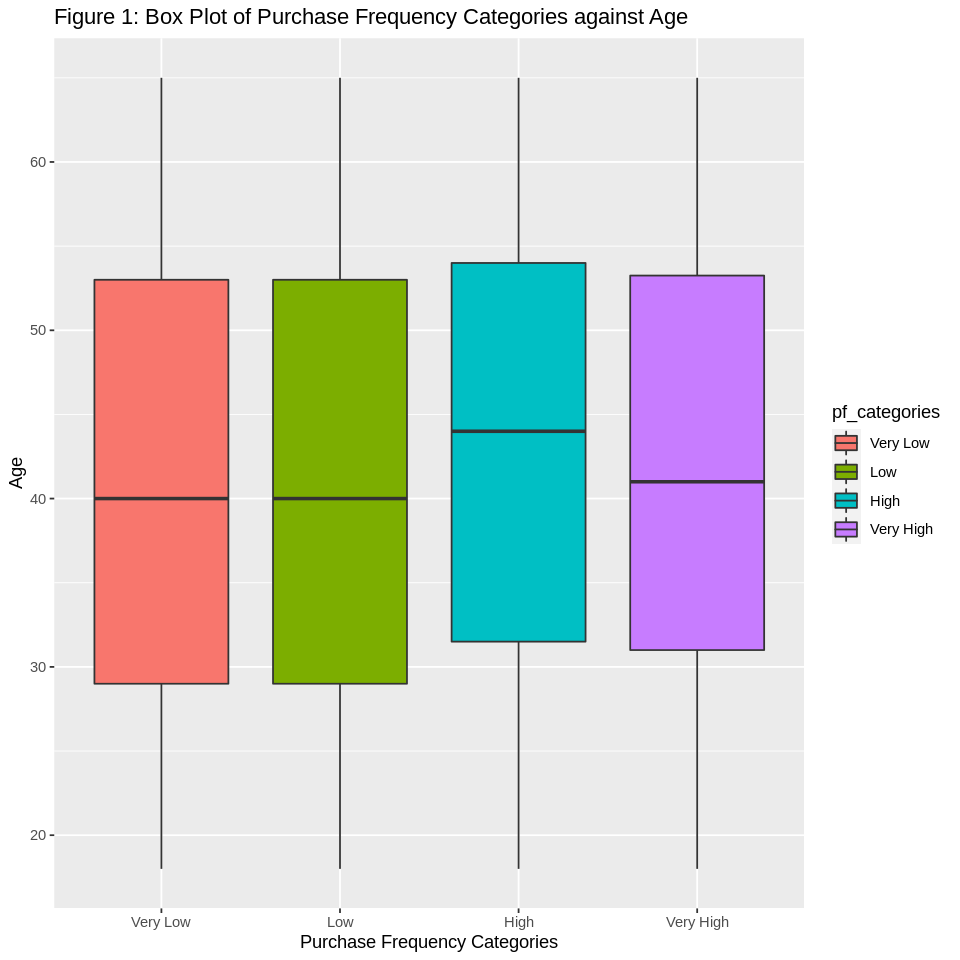

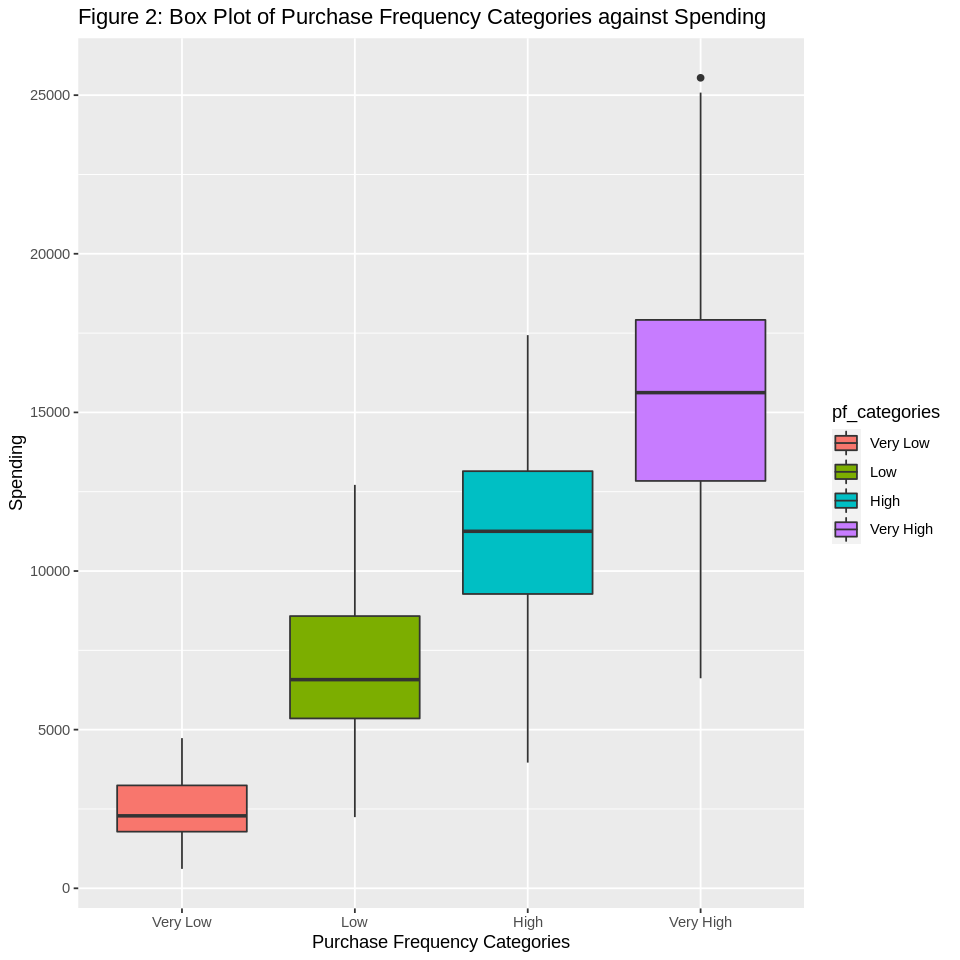

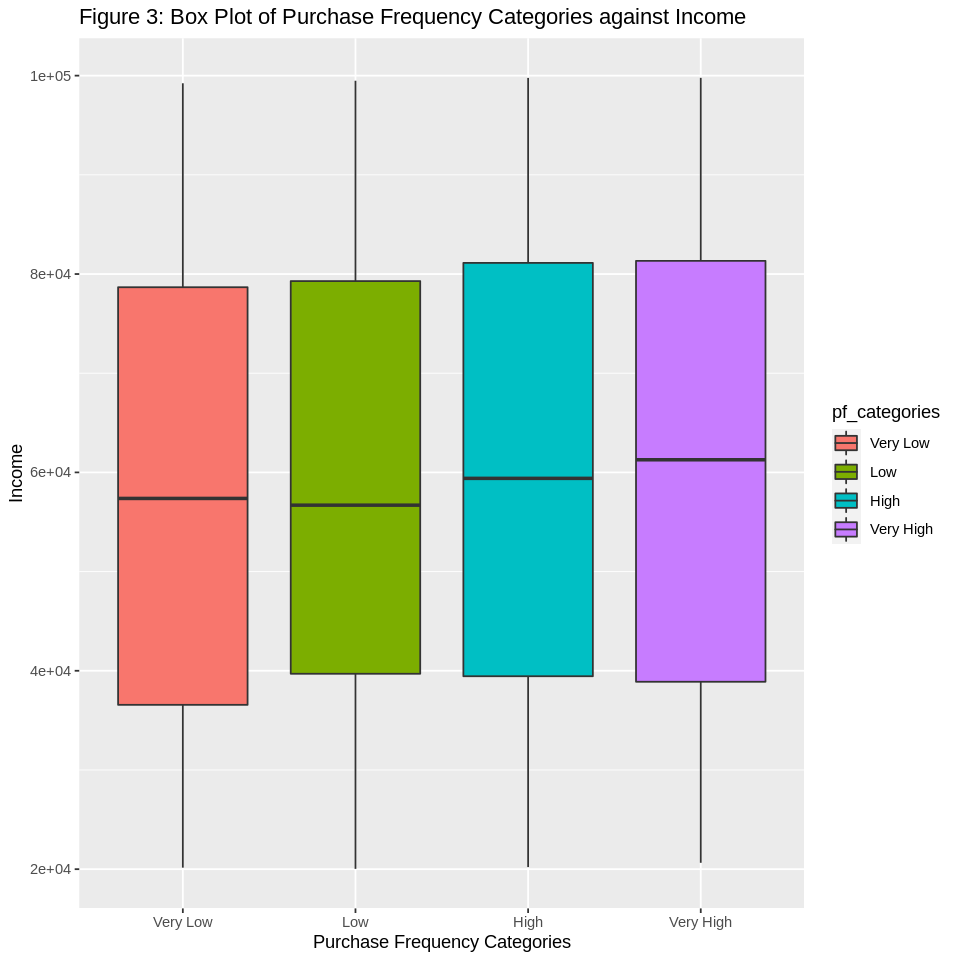

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)

ageplot<- ggplot(train_split, aes(x = pf_categories, y = age, fill = pf_categories)) +
  geom_boxplot() +
  xlab('Purchase Frequency Categories') +
  ylab('Age') +
  ggtitle('Figure 1: Box Plot of Purchase Frequency Categories against Age')

ageplot


spendingplot<- ggplot(train_split, aes(x = pf_categories, y = spending, fill = pf_categories)) +
  geom_boxplot() +
  xlab('Purchase Frequency Categories') +
  ylab('Spending') +
  ggtitle('Figure 2: Box Plot of Purchase Frequency Categories against Spending')

spendingplot


incomeplot<- ggplot(train_split, aes(x = pf_categories, y = income, fill = pf_categories)) +
  geom_boxplot() +
  xlab('Purchase Frequency Categories') +
  ylab('Income') +
  ggtitle('Figure 3: Box Plot of Purchase Frequency Categories against Income')

incomeplot

ANALYSIS OF VISUALIZATIONS TO CHOOSE THE APPROPRIATE VARIABLES FOR OUR MODEL:



<h2><span style='background:#CAFFBF'>Methods & Results:</span></h2>

<span style='color:#FE81BF'> Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. Your report should include code which:
<br>1. loads data from the original source on the web 
<br>2. wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
<br>3. performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
<br>4. creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
<br>5. performs the data analysis
<br>6. creates a visualization of the analysis 
<br>7. note: all tables and figure should have a figure/table number and a legend </span>

In this section we will be creating our classification model with spending and age based on our preliminary data analysis where we concluded these two variables to most likely have an effect on purchase frequency categories. We will then cross validate the model and evaluate accuracy to assess the validity of our model in predicting purchase frequency categories (Very Low, Low, High and Very High) based on these spending and age.

We are going to explore relationship between the variables age, gender, and income and a customer's purchase frequency. 
To do this, we will:
1. Represent purchase frequency as categories instead of numerical values. The categories will be:
    - Very low (0.00-0.25)
    - Low (0.25-0.50) 
    - High (0.50-0.75)   
    - Very high (0.75 - 1.00)
2. Create three separate k-nn classification models, each using only one variable as a predictor. 
3. Tune the number of neighbours used in order to obtain the optimal parameters for each of the three models.
4. Calculate the accuracy of each model's predictions. 
5. Use visualizations to compare the accuracy of the three models. 
6. Determine which variable has the greatest influence on purchase frequency. 
 
For the visualization aspect of our project we will create different plots, each graphing one of the predictor variables for our purchase frequency models (age, gender and income). An example of the plots we will create is given above. We plotted the number of customers within each gender and purchase frequency category. We will construct similar bar charts for age and income. While gender is easily separated into categories, age and income are continuous variables and we will need to make ranges of each of these to plot with purchase frequency categories in bars. Comparing these three plots will give us a visual idea of how each of the predictor variables independently affect purchase frequency.

<h2><span style='background:#9BF6FF'>Discussion:</span></h2>

<span style='color:#FE81BF'>
<br>1. summarize what you found
<br>2. discuss whether this is what you expected to find.
<br>4. discuss what impact could such findings have.
<br>5. discuss what future questions could this lead to. </span>



* We expect to find that people with higher income and age have a higher purchase frequency. 
* We also expect to find gender will not have an impact on purchase frequency.
* These findings could impact how stores will go about marketing their products to people of different economic class' and demographics. The outcome of this data analysis could provide information on which customers a company should advertise towards. 
* Further questions could be asked to analyze which products these individuals with different demographical characteristcs (ex. higher income) prefer and how the advertising affects their purchase frequency.

<h2><span style='background:#CCB7E5'>References:</span></h2>

<span style='color:#FE81BF'>
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well. </span>

Kholis, N., &amp; Ma’rifa, A. (2021, November 19). The influence of price and income on purchase decisions among fast-food consumers: The mediating effect of lifestyle. Go to start page! http://repository.uinsa.ac.id/id/eprint/1904/ 

Lennon, S. J., Sanik, M. M., &amp; Stanforth, N. F. (2003). Motivations for television shopping: Clothing purchase frequency and personal characteristics. Clothing and Textiles Research Journal, 21(2), 63–74. https://doi.org/10.1177/0887302x0302100202 


